<a href="https://colab.research.google.com/github/dstnk0208/wave-search/blob/main/search_wave.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install faiss-gpu

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 85.5 MB 124 kB/s 


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import numpy as np
from scipy import ceil, complex64, float64, hamming, zeros
from scipy.fftpack import fft# , ifft
from scipy import ifft # こっちじゃないとエラー出るときあった気がする
from scipy.io.wavfile import read, write

from matplotlib import pylab as pl

In [5]:
"""
x : 入力信号(モノラル)
win : 窓関数
step : シフト幅
"""
def stft(x, win, step):
    l = len(x) # 入力信号の長さ
    N = len(win) # 窓幅、つまり切り出す幅
    M = int(ceil(float(l - N + step) / step)) # スペクトログラムの時間フレーム数
    
    new_x = zeros(N + ((M - 1) * step), dtype = np.float32)
    new_x[: l] = x # 信号をいい感じの長さにする
    
    # X = zeros([M, N], dtype = complex64) # スペクトログラムの初期化(複素数型)
    X = zeros([M, N], dtype = np.float32) # スペクトログラムの初期化(複素数型)
    for m in range(M):
        start = step * m
        X[m, :] = fft(new_x[start : start + N] * win)
    return X

# =======
#  iSTFT
# =======
def istft(X, win, step):
    M, N = X.shape
    assert (len(win) == N), "FFT length and window length are different."

    l = (M - 1) * step + N
    x = zeros(l, dtype = float64)
    wsum = zeros(l, dtype = float64)
    for m in range(M):
        start = step * m
        ### 滑らかな接続
        x[start : start + N] = x[start : start + N] + ifft(X[m, :]).real * win
        wsum[start : start + N] += win ** 2 
    pos = (wsum != 0)
    x_pre = x.copy()
    ### 窓分のスケール合わせ
    x[pos] /= wsum[pos]
    return x

In [6]:
fftLen = 512 # とりあえず
win = hamming(fftLen) # ハミング窓
step = fftLen // 4

### STFT
rate, data = read('/content/drive/MyDrive/Colab Data/video-search/makurano-soshi.wav')
print(rate)
print(data.shape)
print(data)
master_spectrogram = stft(data, win, step)
target_rate, target_data = read('/content/drive/MyDrive/Colab Data/video-search/search.wav')
target_spectrogram = stft(target_data, win, step)
print(master_spectrogram.shape)
print(target_spectrogram.shape)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: scipy.hamming is deprecated and will be removed in SciPy 2.0.0, use numpy.hamming instead
  


44100
(450560,)
[0 0 0 ... 0 0 0]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: scipy.ceil is deprecated and will be removed in SciPy 2.0.0, use numpy.ceil instead
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: scipy.zeros is deprecated and will be removed in SciPy 2.0.0, use numpy.zeros instead
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: scipy.zeros is deprecated and will be removed in SciPy 2.0.0, use numpy.zeros instead
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: ComplexWarning: Casting complex values to real discards the imaginary part


(3517, 512)
(525, 512)


In [7]:
import scipy.spatial as ss
tree = ss.KDTree(master_spectrogram, leafsize=10)
d, i = tree.query(target_spectrogram, 1)
print('most nearest node:', master_spectrogram[i])
print(d, i)
print(len(d))
print(len(i))

most nearest node: [[   0.           0.           0.        ...    0.           0.
     0.       ]
 [   0.           0.           0.        ...    0.           0.
     0.       ]
 [   0.           0.           0.        ...    0.           0.
     0.       ]
 ...
 [ 418.2618    -385.17914    215.27917   ...   15.675276   215.27917
  -385.17914  ]
 [  14.024044     3.7095406   -7.6017056 ...   -2.399761    -7.6017056
     3.7095406]
 [-315.652      374.3785    -143.61966   ...  -28.403212  -143.61966
   374.3785   ]]
[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.48773544e+00
 1.47296011e+01 6.27534762e+01 2.50535415e+03 3.94582686e+03
 6.19327654e+03 4.36381548e+03 5.05334773e+03 3.00222483e+03
 9.29258924e+03 6.76746492e+03 5.71670150e+03 5.87203510e+03
 4.94429197e+03 5.64854744e+03 4.77697709e+03 1.12984097e+04
 6.25752572e+03 6.09012321e+03 8.12602320e+03 5.206

In [8]:
# 元のwavにKDTreeかけるとRecursionErrorがでる
# RecursionError: maximum recursion depth exceeded while calling a Python object
# data2d = data[:, np.newaxis]
# print(data.shape)
# print(data2d.shape)
# wav_tree = ss.KDTree(data2d, leafsize=10)
# wd, wi = wav=tree.query(target_data2d, 3)
# print('most nearest node:', data2d[wi])
# print(wd, wi)

In [9]:
print(len(d), d)
print(len(i), i)

525 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.48773544e+00
 1.47296011e+01 6.27534762e+01 2.50535415e+03 3.94582686e+03
 6.19327654e+03 4.36381548e+03 5.05334773e+03 3.00222483e+03
 9.29258924e+03 6.76746492e+03 5.71670150e+03 5.87203510e+03
 4.94429197e+03 5.64854744e+03 4.77697709e+03 1.12984097e+04
 6.25752572e+03 6.09012321e+03 8.12602320e+03 5.20633549e+03
 7.08931855e+03 5.60857846e+03 5.73678298e+03 4.92630863e+03
 5.12344532e+03 8.32816625e+03 1.09718724e+04 6.81463806e+03
 7.94437889e+03 1.03584257e+04 6.53706213e+03 6.34621417e+03
 9.41533776e+03 2.02569381e+04 3.29803652e+04 1.55325699e+04
 6.22180743e+03 6.79600148e+03 1.32473132e+04 1.11437437e+04
 7.97385440e+03 1.11616129e+04 9.70938359e+03 4.93998968e+03
 8.48813417e+03 1.56789853e+04 7.50824627e+03 6.49810810e+03
 7.63969127e+03 9.35867015e+03 8.29214180e+03 6.36751245e+03
 6.09948466e+03 6.89

In [10]:
resyn_data = istft(master_spectrogram[i], win, step)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: DeprecationWarning: scipy.zeros is deprecated and will be removed in SciPy 2.0.0, use numpy.zeros instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: DeprecationWarning: scipy.zeros is deprecated and will be removed in SciPy 2.0.0, use numpy.zeros instead
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: scipy.ifft is deprecated and will be removed in SciPy 2.0.0, use scipy.fft.ifft instead


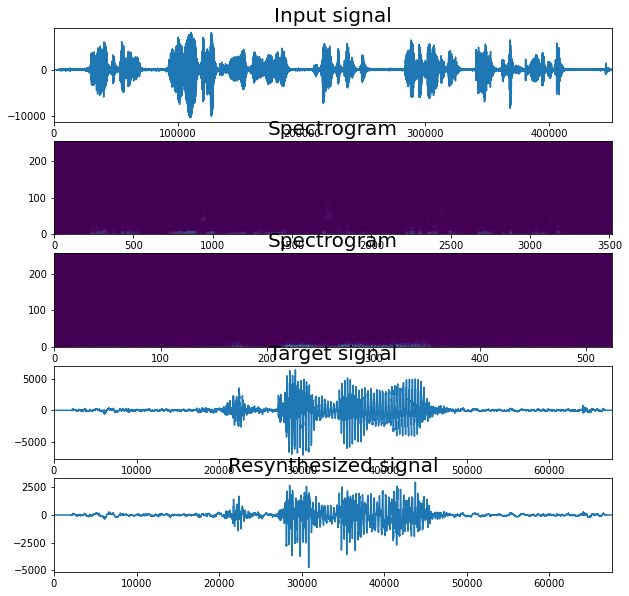

In [24]:
### Plot
fig = pl.figure(figsize=(10,10))
fig.add_subplot(511)
pl.plot(data)
pl.xlim([0, len(data)])
pl.title("Input signal", fontsize = 20)
fig.add_subplot(512)
pl.imshow(abs(master_spectrogram[:, : fftLen // 2 + 1].T), aspect = "auto", origin = "lower")
pl.title("Spectrogram", fontsize = 20)
fig.add_subplot(513)
extracted_spectrogram = master_spectrogram[i]
pl.imshow(abs(extracted_spectrogram[:, : fftLen // 2 + 1].T), aspect = "auto", origin = "lower")
pl.title("Spectrogram", fontsize = 20)
fig.add_subplot(514)
pl.plot(target_data)
pl.xlim([0, len(target_data)])
pl.title("Target signal", fontsize = 20)
fig.add_subplot(515)
pl.plot(resyn_data)
pl.xlim([0, len(resyn_data)])
pl.title("Resynthesized signal", fontsize = 20)
pl.show()

In [26]:
print(resyn_data.shape)
# write('/content/drive/MyDrive/Colab Data/video-search/search_result.wav', rate, resyn_data) 酷いノイズ
# resyn_dataをwav変換するとあけぼのになることを期待しているが､ノイズになるのはなぜだろう（512次元のスペクトログラムを525次元に変換しているからか）
# write('/content/drive/MyDrive/Colab Data/video-search/search_result.wav', rate, data[i]) 再生されない
# write('/content/drive/MyDrive/Colab Data/video-search/search_result.wav', rate, data)
# print(len(data), data)
# print(len(i), i)
# print(np.where(master_spectrogram == i))
# print(len(target_data))
# print(len(resyn_data))
# print(data[resyn_data])

(67584,)


In [13]:
# import numpy as np

# def cos_sim(v1, v2):
#   return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

# # 異なる2つのベクトルを受け取り､2つ目のベクトルの次元数を単位として逐次コサイン類似度を求め結果をlistで返す
# def search_vec(v1, v2):
#   similarities = []
#   search_dim = len(v2)
#   stop_dim = len(v1) - len(v2)
#   for head in range(0, stop_dim, search_dim):
#     print("---", head, search_dim, "---")
#     similarity = cos_sim(v1[head:head+search_dim], v2)
#     print(similarity)
#     similarities.append(similarity)
#   return similarities

In [14]:
# print(search_vec(data, target_data))

In [15]:
import faiss
d = 512
index = faiss.IndexFlatL2(d)
index.is_trained
index.add(master_spectrogram)
index.ntotal
k = 1
D, I = index.search(target_spectrogram, k)  # search
print(I)
print(master_spectrogram[I])

[[   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [   0]
 [  10]
 [  24]
 [ 701]
 [3335]
 [2129]
 [3312]
 [3417]
 [ 573]
 [1997]
 [ 176]
 [ 626]
 [3333]
 [3461]
 [2160]
 [2087]
 [2105]
 [1619]
 [3344]
 [ 133]
 [1232]
 [3306]
 [3404]
 [ 116]
 [2170]
 [1610]
 [3439]
 [1598]
 [2088]
 [ 562]
 [ 683]
 [1992]
 [1550]
 [2640]
 [2541]
 [2960]
 [ 142]
 [ 194]
 [ 206]
 [2647]
 [2576]
 [ 653]
 [ 577]
 [3258]
 [3445]
 [ 201]
 [2640]
 [ 185]
 [1916]
 [2037]
 [3237]
 [ 125]
 [3409]
 [ 192]
 [2161]
 [3409]
 [2035]
 [ 602]
 [3417]
 [3355]
 [ 581]
 [ 607]
 [3386]
 [1621]
 [3284]
 [3366]
 [ 603]
 [3246]
 [2616]
 [1616]
 [ 157]
 [ 684]
 [3265]
 [ 684]
 [ 624]
 [2070]
 [ 140]
 [3308]
 [3299]
 [ 672]
 [ 118]
 [2615]
 [2066]
 [2132]
 [3431]
 [ 631]
 [1906]
 [ 701]
 [3323]
 [2595]
 [3401]
 [3453]
 [ 587]
 [3335]
 [ 650]
 [2080]
 [ 642]
 [ 672]
 [2156]
 [3288]
 [2181]
 [3394]
 [3291]
 [2164]
 [1563]
 [2034]
 [1591]
 [3340]
 [3366]
 [2150]
 [1614]
 [2206]
 [1616]
